/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


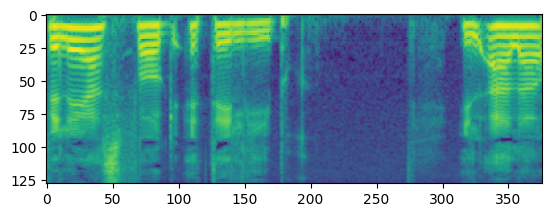

In [13]:
import torch,torchaudio,torchvision
import librosa 
import numpy as np
import matplotlib.pyplot as plt

SR =16000
FRAME_LEN=3
feature_type = 'mel'
if feature_type == 'spectrogram':
    transform = torchaudio.transforms.Spectrogram(n_fft=512,hop_length=512//4,normalized=True)
else: 
    transform = torchaudio.transforms.MelSpectrogram(n_fft=512,sample_rate=SR,hop_length=512//4,normalized=True,n_mels=128)
transform_channels = torchvision.transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)

def amplitude_envelope_start_stop(signal, frame_size=512, hop_length=256,sr=16000):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): 
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) 
        amplitude_envelope.append(amplitude_envelope_current_frame)
    env= np.array(amplitude_envelope)
    t = librosa.frames_to_time(range(len(env)),sr = sr,hop_length=hop_length)
    start = 0
    stop = len(env)-1
    for i in range(len(env)):
        if env[i]>0.1:
            start = i
            break
    for i in range(len(env),0):
        if env[i]>0.1:
            stop = i
            break
    return t[start],t[stop]
path = '/dsi/gannot-lab1/LibriSpeech_mls_french/Test/296/486/296_486_000000.wav'
wav,fs = torchaudio.load(path)
wav = wav/torch.max(abs(wav)) #norm
wav=wav.flatten()
env_start,env_stop = amplitude_envelope_start_stop(wav)
wav = wav[int(env_start*SR):int((env_start+FRAME_LEN)*SR)]

feature_image= transform(wav).unsqueeze(0)
feature_image_gs = transform_channels(feature_image)

plt.imshow(20*torch.log10(feature_image[0]+1e-9))